In [2]:
%pip install imutils
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [63]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream


import time

In [51]:
# to detect face feature
import dlib
predictor_model = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()# dlib人脸检测器
predictor = dlib.shape_predictor(predictor_model)


In [3]:
def readFiles(path):
    img = cv2.imread(path)
    return img

In [4]:
detectors = {
    "eye": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_eye.xml']),
    "face": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_frontalface_default.xml'])
}
def detect(gray, part="face"):
    
    detector = cv2.CascadeClassifier(detectors[part])
    rects = detector.detectMultiScale(gray, scaleFactor=2, minNeighbors=5, minSize=(15, 15),
                                      flags=cv2.CASCADE_SCALE_IMAGE)
    return rects

In [5]:
def Recording():
    
    # open webcam
    vs = WebcamVideoStream().start()
    start = time.time()
    fps = vs.stream.get(cv2.CAP_PROP_FPS)
    print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    while True:
        # turn to gray image to detect face
        frame = vs.read()
        img = frame.copy()
        img = imutils.resize(img, width=300)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 呼叫偵測函數，取得結果
        rects = detect(gray)
        
        # 繪出偵測結果 (記得將偵測的座標轉回原本的frame大小)
        ratio = frame.shape[1] / img.shape[1]
        for rect in rects:
            rect = rect * ratio
            (x, y, w, h) = rect.astype("int")
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # 標示FPS
        end = time.time()
        text = f"FPS: {str(int(1 / (end - start)))}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        start = end

        # 顯示影像
        cv2.imshow("Frame", frame)

        # 判斷是否案下"q"；跳離迴圈
        key = cv2.waitKey(1) & 0xff
        if key == ord('q'):
            break

    #  清除畫面與結束WebCam
    cv2.destroyAllWindows()
    vs.stop()




In [6]:
def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [7]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def GetFaceMask(img):
    img, Gimg = img2Gray(img)
    rects = detect(Gimg) # return multi-face
    
    # Face mask, cut out of face region
    Facemask = np.zeros_like(img)
    (y, x, w, h) = rects[0].astype("int")
    Facemask = cv2.rectangle(Facemask, (y,x), (y + w, x + h), (255,255,255), -1)
    
    return Facemask

In [9]:
def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result

In [10]:
def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return skinMask


In [92]:
def get_landmarks(Gimg):

    predictor_model = 'shape_predictor_68_face_landmarks.dat'
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_model)
    rects = detector(Gimg, 0)

    for i in range(len(rects)):
        landmarks = np.matrix([[p.x, p.y] for p in predictor(Gimg, rects[i]).parts()])
#     print(landmarks)
    return landmarks


In [81]:
def get_image_hull_mask(image_shape, image_landmarks, ie_polys=None):
    # get the mask of the image
    if image_landmarks.shape[0] != 68:
        raise Exception(
            'get_image_hull_mask works only with 68 landmarks')
    int_lmrks = np.array(image_landmarks, dtype=np.int)

    #hull_mask = np.zeros(image_shape[0:2]+(1,), dtype=np.float32)
    hull_mask = np.full(image_shape[0:2] + (1,), 0, dtype=np.float32)

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[0:9],
                        int_lmrks[17:18]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[8:17],
                        int_lmrks[26:27]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:20],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[24:27],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[19:25],
                        int_lmrks[8:9],
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:22],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[22:27],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    # nose
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(int_lmrks[27:36]), (255,255, 255))

    if ie_polys is not None:
        ie_polys.overlay_mask(hull_mask)
    print()
    return hull_mask

In [96]:
if __name__ == "__main__":
    
    #Read Image
    img = cv2.imread('data/acne_face.jpeg')
    img,Gimg = img2Gray(img)
    
#     # Method 1 to get face (Skin Detection and Face Detection(Harr))
#     skinMask = GetSkinMask(img)
#     faceMask = GetFaceMask(img)
    
    # Method 2 to get face (Use Dlib)
    StartTime = time.time()
    landmarks = get_landmarks(Gimg)
    img_cnt = np.zeros(img.shape[:-1])
    image_draw = np.copy(img_cnt)

    face = np.vstack([np.array(landmarks[:,0]), np.array(landmarks[:,1])]).T
    print([np.array(landmarks[:,0]), np.array(landmarks[:,1])])
    cv2.fillPoly(img_cnt, pts = np.int(face), color=(1))
    image_draw[img_cnt == 0] = 0


    
    # combine two mask
    Face_Skin_Mask = cv2.bitwise_and(skinMask, faceMask)
    cv2.imwrite('ClearMask.png', mask)
    showImage(image_draw)


    

[array([[347],
       [352],
       [361],
       [371],
       [394],
       [432],
       [478],
       [526],
       [583],
       [639],
       [693],
       [743],
       [785],
       [813],
       [828],
       [841],
       [848],
       [377],
       [406],
       [452],
       [497],
       [539],
       [640],
       [683],
       [730],
       [777],
       [811],
       [588],
       [586],
       [586],
       [584],
       [538],
       [560],
       [584],
       [609],
       [634],
       [428],
       [454],
       [489],
       [520],
       [487],
       [452],
       [660],
       [691],
       [726],
       [755],
       [728],
       [692],
       [477],
       [518],
       [557],
       [584],
       [611],
       [652],
       [697],
       [654],
       [612],
       [583],
       [554],
       [516],
       [492],
       [557],
       [584],
       [611],
       [682],
       [612],
       [584],
       [556]]), array([[424],
       [491],
       [555],
   

/var/folders/fl/0gvtd2b94r578g4v1cqx9vn40000gn/T/ipykernel_5789/3474164463.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cv2.fillPoly(img_cnt, pts = np.int(face), color=(1))


TypeError: only size-1 arrays can be converted to Python scalars

In [84]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
landmarks = get_landmarks(img)

mask = get_image_hull_mask(np.shape(img), landmarks).astype(np.uint8)

image_bgra = merge_add_alpha(img, mask)
image_bgr = merge_add_mask(img, mask)

/var/folders/fl/0gvtd2b94r578g4v1cqx9vn40000gn/T/ipykernel_5789/2483660853.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)


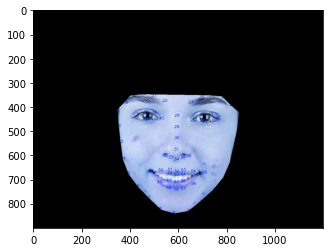

In [48]:
showImage(image_bgr)

In [101]:
img = cv2.imread('data/acne_face.jpeg')
face = cv2.imread('data/acne_face.jpeg')
img = cv2.bitwise_and(img, face)

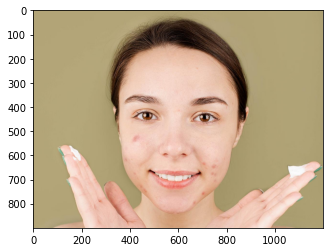

In [102]:
showImage(img)